In [33]:
# Standard Library Imports
import sys
import os
import time

import numpy as np
import tensorflow as tf

from src.ddp.ddp_debt import DebtModelDDP

# Notebook Magic & Configuration
%load_ext autoreload
%autoreload 2

# Add the project root to the path so we can import 'src'
sys.path.append(os.path.abspath('..'))

# Local/Project Imports
from src.ddp.utils import ModelParameters
from src.ddp.ddp_investment import InvestmentModelDDP
from src.ddp.ddp_debt import DebtModelDDP
from src.ddp.simulation import run_parameter_sweep, process_investment_output, process_debt_output
from src.ddp.visuals import set_plot_style, plot_investment_policies, plot_investment_moments_vs_shocks, plot_debt_policies, plot_debt_moments_vs_shocks

# Initialization
set_plot_style()

# Check TF versions
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
TensorFlow Version: 2.16.2
GPU Available: True


### Benchmarking VFI versus PFI
Let's solve for the discrete dynamic programming (DDP) problem to find firm's optimal investment. As a first sanity check, I implement two standard algorithms and compare their results and execution time:
- **Value Function Iteration (VFI)**
- **Policy Function Iteration (PFI)**

As in the basic model, I consider the case of no fixed adjustment cost, `cost_fixed=0`, and a small and convex marginal adjustment cost, `cost_convex=0.01`.

In [11]:
# Directly called the functions from ddp_investment.py
# Compare VFI and PFI
# Use default parameters generated by ModelParameters()
params_base = ModelParameters()
model = InvestmentModelDDP(params_base)

# --- Benchmark VFI ---
print(f"{'='*10} Starting Value Function Iteration (VFI) {'='*10}")
start_time = time.time()

# Note: VFI needs many iterations to converge (slow decay of error)
v_vfi, policy_vfi = model.solve_invest_vfi(tol=1e-6, max_iter=2000)

time_vfi = time.time() - start_time
print(f"VFI Time: {time_vfi:.4f} seconds\n")

# --- Benchmark PFI ---
print(f"{'='*10} Starting Policy Function Iteration (PFI) {'='*10}")
start_time = time.time()

# Note: PFI converges in very few "outer" steps (Newton's method)
v_pfi, policy_pfi = model.solve_invest_pfi(max_iter=100, eval_steps=200)

time_pfi = time.time() - start_time
print(f"PFI Time: {time_pfi:.4f} seconds\n")

# --- Comparison Report ---
print(f"{'='*10} Comparison Report {'='*10}")
print(f"Speedup Factor (VFI / PFI): {time_vfi / time_pfi:.2f}x")

# Check Max Difference in Value Functions
v_diff = np.max(np.abs(v_vfi - v_pfi))
print(f"Max Difference in Value Function: {v_diff:.2e}")

# Check Max Difference in Policy (Capital Choice)
p_diff = np.max(np.abs(policy_vfi - policy_pfi))
print(f"Max Difference in Policy Function: {p_diff:.2e}")

# Visualization of Consistency
if p_diff < 1e-5:
    print("\nSUCCESS: Both solvers produced identical policies.")
else:
    print("\nWARNING: Solvers disagreed on policy. Check tolerances.")

========== Starting Value Function Iteration (VFI) ==========
VFI Converged in 377 steps. Error: 0.00e+00
VFI Time: 0.9471 seconds

========== Starting Policy Function Iteration (PFI) ==========
PFI Converged in 6 steps.
PFI Time: 2.5164 seconds

========== Comparison Report ==========
Speedup Factor (VFI / PFI): 0.38x
Max Difference in Value Function: 0.00e+00
Max Difference in Policy Function: 0.00e+00

SUCCESS: Both solvers produced identical policies.


Now we can implement our model using the recommended pipeline. We can override the default parameters and defined our own benchmark.

In [26]:
# 1. Define Base Parameters
params_base = ModelParameters(
    r_rate=0.04,
    delta=0.15,
    theta=0.7,
    rho=0.7,
    sigma=0.15,
    cost_convex=0.05,
    cost_fixed=0.05,
    z_size=15,
    k_size=100
)

# 2. Define Scenarios (Comparative Statics)
# We compare the Baseline against a "High Volatility" environment
scenarios = {
    "Baseline": {},  # Empty dict means "use base params"
    "High Volatility": {"sigma": 0.30},
    "No Adjustment Cost": {"cost_fixed": 0.0, "cost_convex": 0.0},
    "High Adjustment Cost": {"cost_fixed": 0.1, "cost_convex": 0.1},
}

# 3. Run Simulation (Heavy Computation)
# This returns the raw tensors from the solver
raw_results = run_parameter_sweep(
    model_class=InvestmentModelDDP,
    base_params=params_base,
    scenarios=scenarios,
    solver_method="solve_invest_vfi", # Or "solve_invest_pfi"
    solver_kwargs={"max_iter": 1000, "tol": 1e-5}
)

# 4. Post-Process (Data Analysis)
# This converts tensors to NumPy and calculates moments (i/k, surplus, etc.)
clean_data = process_investment_output(raw_results)


--- Starting Parameter Sweep for InvestmentModelDDP ---
[1/4] Running Scenario: 'Baseline'...
VFI Converged in 399 steps. Error: 0.00e+00
   > Completed in 1.06 seconds.
[2/4] Running Scenario: 'High Volatility'...
VFI Converged in 390 steps. Error: 0.00e+00
   > Completed in 0.93 seconds.
[3/4] Running Scenario: 'No Adjustment Cost'...
VFI Converged in 340 steps. Error: 0.00e+00
   > Completed in 0.81 seconds.
[4/4] Running Scenario: 'High Adjustment Cost'...
VFI Converged in 424 steps. Error: 0.00e+00
   > Completed in 0.97 seconds.

--- Processing Investment Output ---


Plotting for median productivity shock: z index 7


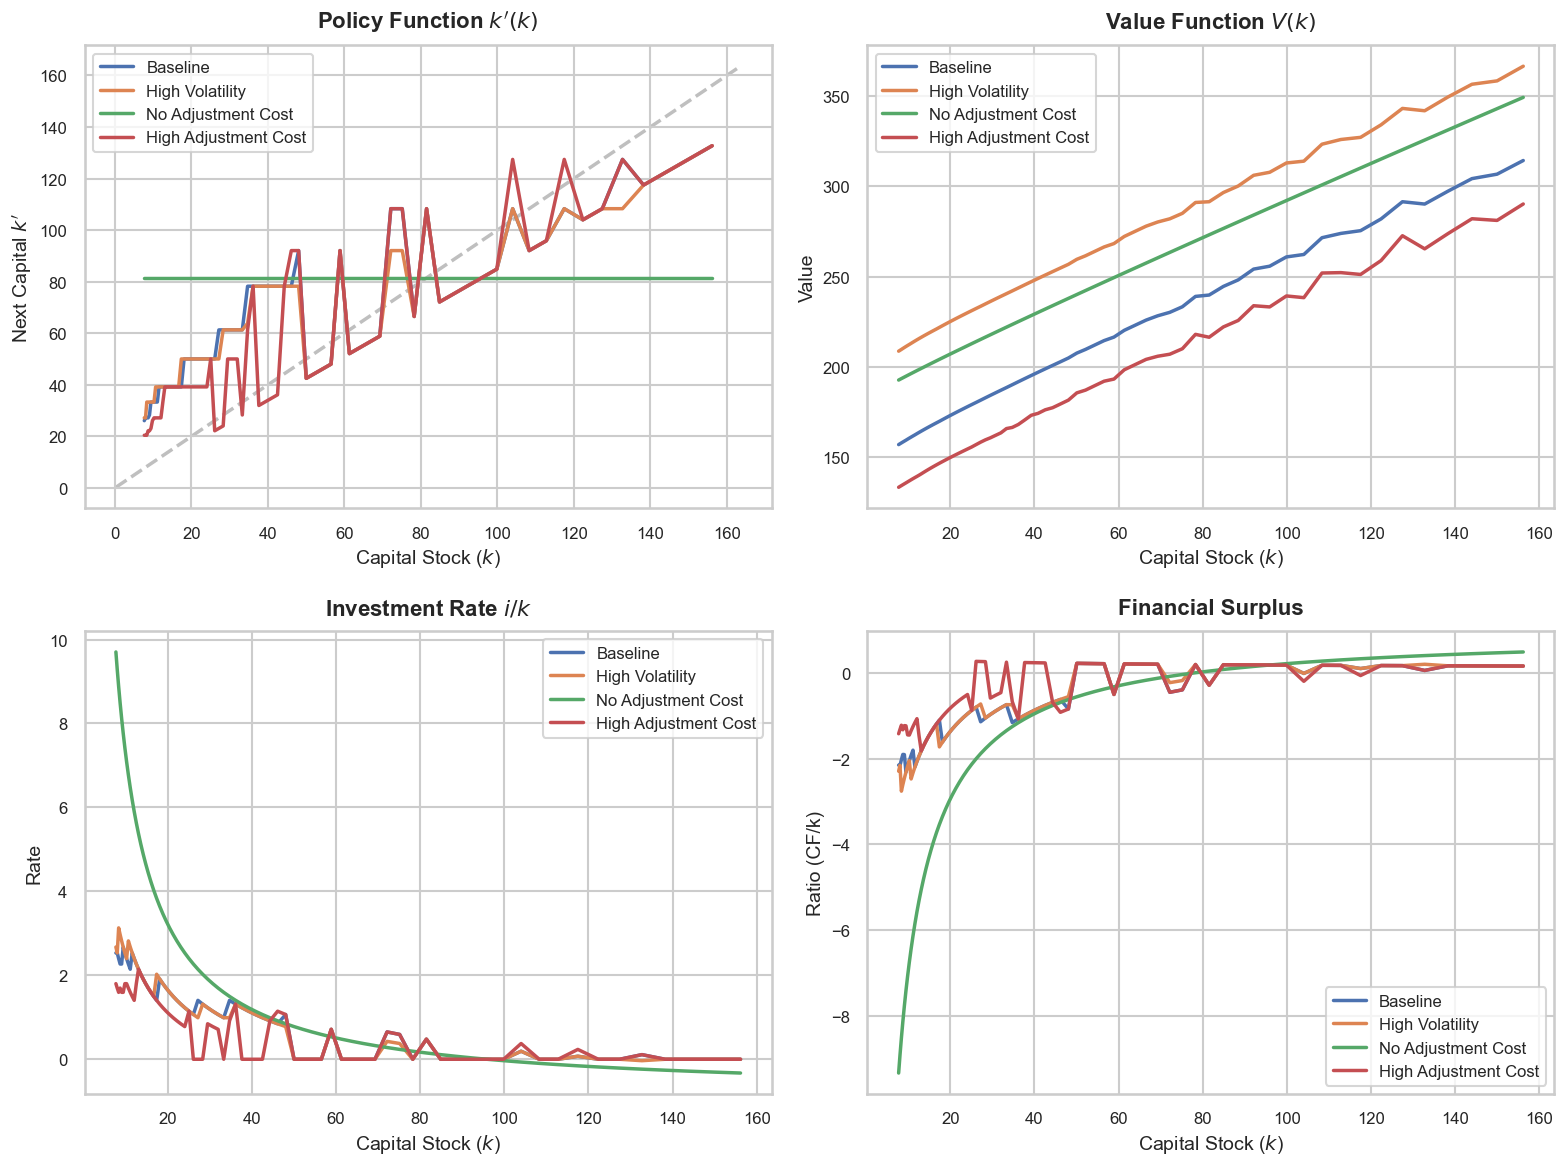

In [27]:
# Plots the 2x2 dashboard (Policy, Value, Investment Rate, Surplus)
# z_idx=None defaults to the median productivity state
plot_investment_policies(clean_data, z_idx=None)

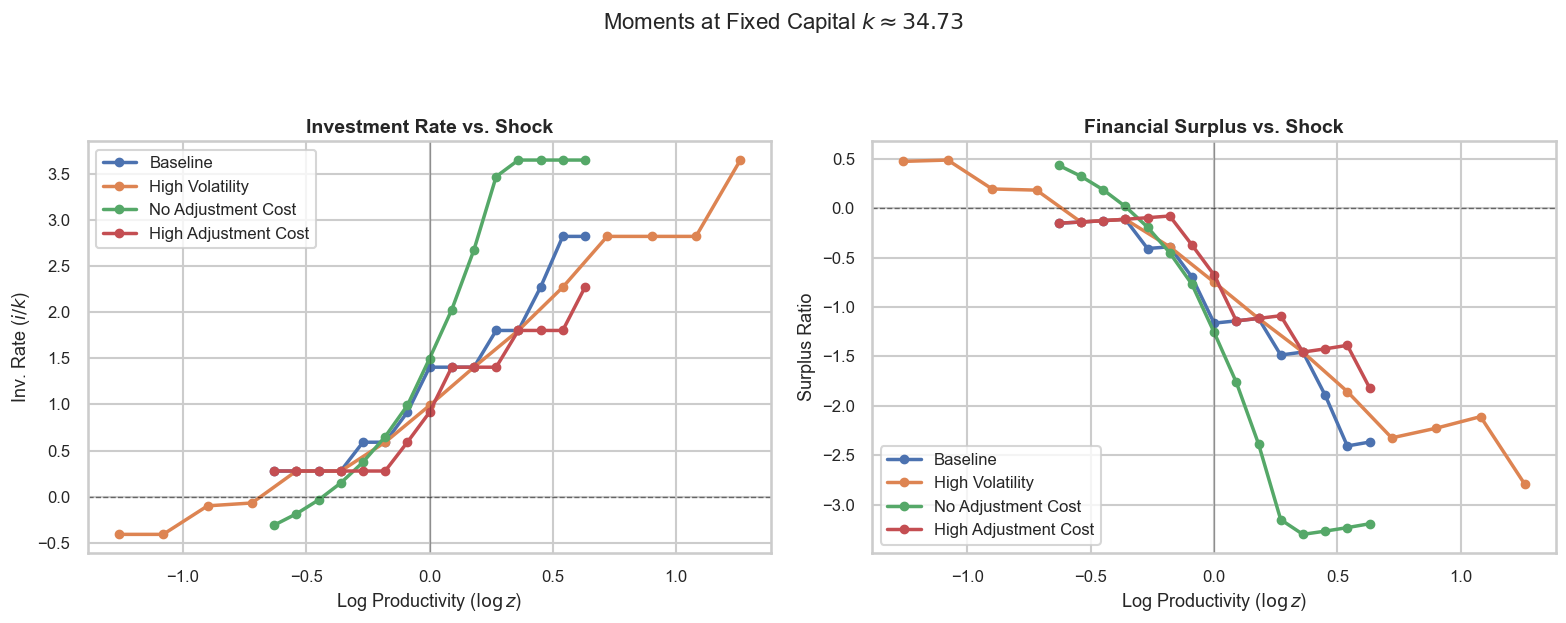

In [28]:
# Plots how Investment and Surplus respond to productivity shocks (z)
# Fixes capital (k) at the median level (or specify k_idx)
plot_investment_moments_vs_shocks(clean_data)

## Risky Debt Model

#### Algorithm: Strategic Default Solver ("Loop-within-a-Loop")

This algorithm solves for the **Endogenous Bond Price** $q(z, k', b')$ and **Firm Value** $V(z, k, b)$ simultaneously. Unlike structural models where default is determined by asset thresholds, here default is a strategic choice: shareholders walk away (default) whenever the equity value $V$ drops below zero.

Because the bond price depends on the firm's default decision, and the default decision depends on the bond price (cheap debt increases value), we must solve the system iteratively.

### Step 1: Initialization (Outer Loop Start)
We begin by assuming the firm is **risk-free**. The bank initially trusts the firm completely and offers the risk-free price for all debt levels.

* **Initial Guess:** Set the bond price schedule $q^{(0)}$ equal to the risk-free discounted face value.
$$
q^{(0)}(z, k', b') = \frac{b'}{1 + r}
$$
* **Economic Implication:** The bank assumes the probability of default is zero for all states.

### Step 2: Solve Firm Problem (Inner Loop)
The firm takes the current market price schedule $q^{(i)}$ as given (Price Taker). We solve the standard Bellman equation to find the firm's optimal policy and value.

* **Objective:** Solve for the Value Function $V^{(i)}(z, k, b)$.
* **Bellman Equation:**
$$
V^{(i)}(z, k, b) = \max \left( 0, \max_{k', b'} \left\{ \text{Div}(z, k, b, k', b' \mid q^{(i)}) + \beta \mathbb{E}_{z'} V^{(i)}(z', k', b') \right\} \right)
$$
* **Limited Liability:** The outer $\max(0, \dots)$ reflects the shareholders' option to walk away. If the continuation value is negative, the equity value is zero.

### Step 3: Update Bond Prices (The "Strategic" Update)
The bank observes the firm's value function $V^{(i)}$ from Step 2 and updates its pricing model. The bank anticipates that the firm will default in any future state $(z', k', b')$ where the value is negative.

* **Identify Default States:**
$$
\text{Default}^{(i)}(z', k', b') = \begin{cases} 1 & \text{if } V^{(i)}(z', k', b') < 0 \\ 0 & \text{if } V^{(i)}(z', k', b') \ge 0 \end{cases}
$$
* **Calculate Lender Payoff:**
$$
\text{Payoff}(z') = (1 - \text{Default}) \cdot b' + \text{Default} \cdot \text{Recovery}(z', k')
$$
* **New Price Schedule ($q^{(i+1)}$):**
$$
q^{(i+1)}(z, k', b') = \frac{1}{1+r} \mathbb{E}_{z'} \left[ \text{Payoff}(z') \right]
$$

### Step 4: Check Convergence
We compare the new price schedule $q^{(i+1)}$ with the previous schedule $q^{(i)}$.

* **Convergence Metric:** Calculate the maximum absolute difference (infinity norm):
$$
\epsilon = \max \left| q^{(i+1)} - q^{(i)} \right|
$$
* **Decision:**
    * **If $\epsilon < \text{tolerance}$ (e.g., $10^{-4}$):** The model has converged. The prices are consistent with the firm's default incentives. **Stop.**
    * **If $\epsilon \ge \text{tolerance}$:** Set $q^{(i)} = q^{(i+1)}$ and return to **Step 2**.

In [35]:
debt_params = ModelParameters(
    # Structural
    r_rate=0.04,        # Risk-free rate (beta ~ 1/(1+r))
    delta=0.15,         # Depreciation
    theta=0.7,         # Decreasing Returns to Scale

    # Stochastic Process (Productivity)
    rho=0.7,            # Persistence
    sigma=0.15,          # Volatility
    z_size=5,           # Number of productivity states

    # Number of Capital Grids
    k_size=50,

    # Number of Debt Grids
    b_size=50,

    # Frictions / Costs
    tax=0.30,           # Corporate Tax Rate
    cost_default=0.7,   # Fraction of assets lost in bankruptcy

    cost_inject_fixed=0.05,   # Fixed cost of external finance
    cost_inject_linear=0.05,  # Linear cost of external finance

    cost_convex=0.01,   # Marginal capital adjustment cost
    cost_fixed=0.01     # Fixed capital adjustment cost
)

# Define scenarios
debt_scenarios = {
    "Baseline": {}, # Empty means using baseline parameters
}

# Collect results
results_debt = run_parameter_sweep(
    model_class=DebtModelDDP,             # DebtModelDDP or InvestmentModelDDP
    base_params=debt_params,
    scenarios=debt_scenarios,
    solver_method="solve_risky_debt_vfi",     #solve_invest_vfi or solve_risky_debt_vfi
    solver_kwargs={'tol': 1e-4, 'damping_weight': 1.0}
)

<unknown>:242: SyntaxWarning: invalid escape sequence '\l'
<unknown>:260: SyntaxWarning: invalid escape sequence '\l'



--- Starting Parameter Sweep for DebtModelDDP ---
[1/1] Running Scenario: 'Baseline'...
Starting Risky Debt Solver (Damping=1.0)...
    VFI Converged: 41 iters, Diff=0.000004
    VFI Converged: 39 iters, Diff=0.000008
    VFI Converged: 44 iters, Diff=0.000004
    VFI Converged: 48 iters, Diff=0.000004
    VFI Converged: 45 iters, Diff=0.000004
    VFI Converged: 46 iters, Diff=0.000000
    VFI Converged: 46 iters, Diff=0.000008
    VFI Converged: 48 iters, Diff=0.000008
    VFI Converged: 65 iters, Diff=0.000000
    VFI Converged: 79 iters, Diff=0.000004
    VFI Converged: 84 iters, Diff=0.000004
    VFI Converged: 103 iters, Diff=0.000008
    VFI Converged: 125 iters, Diff=0.000004
    VFI Converged: 129 iters, Diff=0.000004
    VFI Converged: 126 iters, Diff=0.000008
    VFI Converged: 162 iters, Diff=0.000002
    VFI Converged: 257 iters, Diff=0.000008
    VFI Converged: 292 iters, Diff=0.000008
    VFI Converged: 353 iters, Diff=0.000001
    VFI Converged: 329 iters, Diff=0.00000

In [38]:
# 2. PROCESS the results (Creates 'grids', 'moments', numpy arrays)
clean_debt_data = process_debt_output(results_debt)


--- Processing Debt Output ---


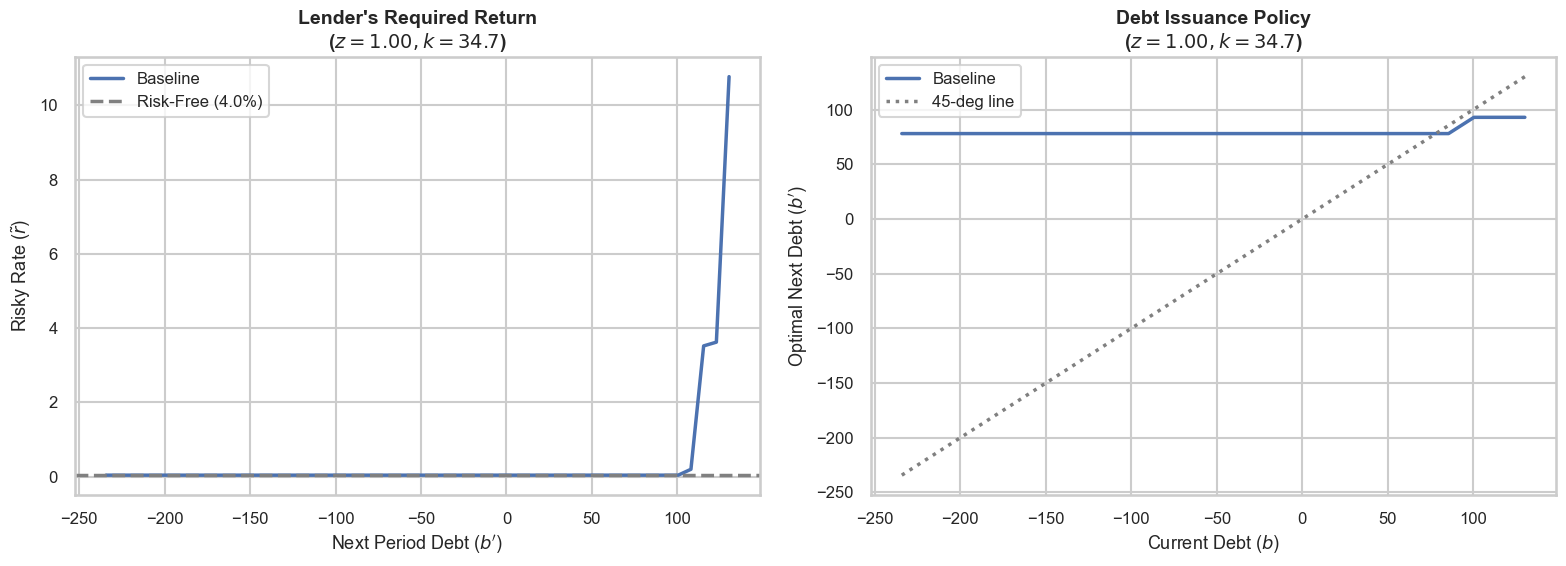

In [39]:
plot_debt_policies(clean_debt_data)

Moments vs Shocks (Slice at Baseline SS):
  k_ss = 16.714, b_ss = 85.587


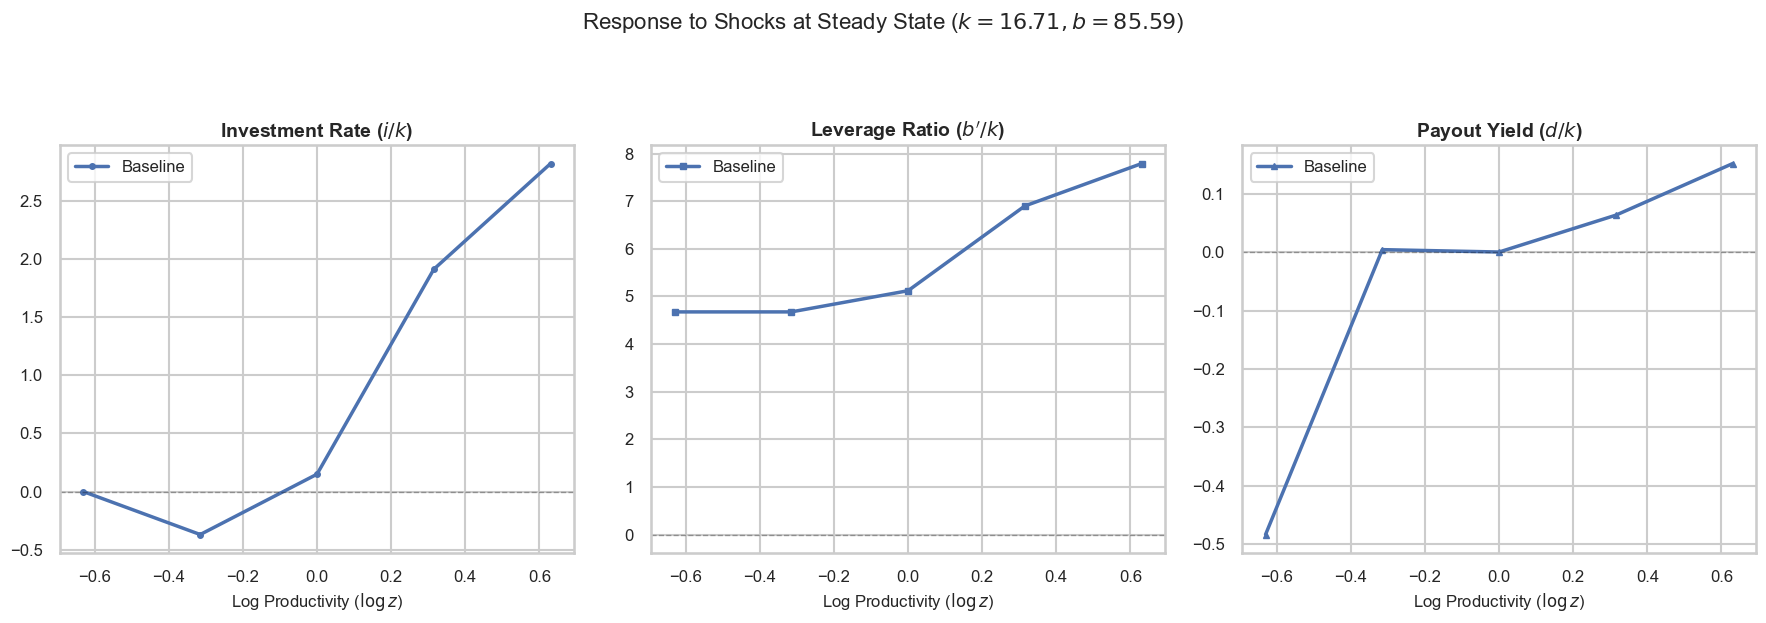

In [40]:
plot_debt_moments_vs_shocks(clean_debt_data)